In [143]:
import requests
import json
import pandas as pd
import time
import re
import urllib
import matplotlib
pd.set_option('display.max_colwidth', None)

In [144]:
address = "terra1w579ysjvpx7xxhckxewk8sykxz70gm48wpcuruenl29rhe6p6raslhj0m6"

In [145]:
def get_txs_time_period(_from, _to):
    _df = None
    timestamp = urllib.parse.quote(_from.strftime("%Y-%m-%d+%H:%M:%S"),safe='+')
    while True:
        url = f"""
        https://api.seer.coinhall.org/api/coinhall/swaps/{address}?offset={timestamp}.010646870&limit=15
        """
        print(url)
        # Send a GET request to the API
        response = requests.get(url)
    
        time.sleep(1)
        print(f"Number of txs received: {len(response.json()['txs'])}")
        
        new_df = pd.DataFrame(response.json()['txs'])
        if _df is None:
            _df = new_df
        else:
            _df = pd.concat([_df, new_df])
        _df.timestamp = pd.to_datetime(_df.timestamp)
        min_ts = _df.timestamp.min()
        timestamp = urllib.parse.quote(min_ts.strftime("%Y-%m-%d+%H:%M:%S"),safe='+')

        if(min_ts.to_pydatetime().replace(tzinfo=None) < _to):
            break
    return _df

In [146]:
from datetime import datetime, timedelta

current_date = datetime.now()
threshold_day = current_date - timedelta(days=50)

In [147]:
try:
    df = pd.read_csv("./data/astro/swaps.csv")
    df.timestamp = pd.to_datetime(df.timestamp, format='mixed')
except Exception as e:
    print(f"No file yet {e}")
    df = None

if df is None:
    print("No data yet. Downloading it all...")
    df = get_txs_time_period(current_date, threshold_day)
else:
    if df.timestamp.max().to_pydatetime().replace(tzinfo=None) < current_date:
        print(f"Filling the upper gap from {current_date.strftime('%Y-%m-%d')} to {df.timestamp.max().to_pydatetime().replace(tzinfo=None).strftime('%Y-%m-%d')}")
        tt_df = get_txs_time_period(current_date, df.timestamp.max().to_pydatetime().replace(tzinfo=None))
        df = pd.concat([df, tt_df])
    if df.timestamp.min().to_pydatetime().replace(tzinfo=None) > threshold_day:
        print(f"Filling the upper gap from {threshold_day.strftime('%Y-%m-%d')} to {df.timestamp.min().to_pydatetime().replace(tzinfo=None).strftime('%Y-%m-%d')}")
        tt_df = get_txs_time_period(df.timestamp.min().to_pydatetime().replace(tzinfo=None), threshold_day)
        df = pd.concat([df, tt_df])
df = df.drop_duplicates(ignore_index=True)

In [148]:
assets = {
    'ibc/B3504E092456BA618CC28AC671A71FB08C6CA0FD0BE7C8A5B5A3E2DD933CC9E4':'axlUSDC',
    'terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26':'ASTRO'
}

In [149]:
df = df.drop_duplicates(ignore_index=True)
df.returnAsset = df.returnAsset.replace(assets)
df.offerAsset = df.offerAsset.replace(assets)

In [150]:
df['date'] = df.timestamp.apply(lambda x: x.strftime("%Y-%m-%d"))

In [151]:
astro_sell = df[df.offerAsset=='ASTRO']

In [ ]:
astro_sell

In [161]:
tt = astro_sell[astro_sell.date >= '2023-07-01']\
    [['traderAddress','returnAmount']]\
    .groupby('traderAddress')\
    .sum().sort_values(by='returnAmount', ascending=False).reset_index().head(50)
json_data = tt.to_json(orient='records')
with open("./data/astro/top_sellers.json", 'w') as f:
    f.write(json_data)

<Axes: xlabel='date'>

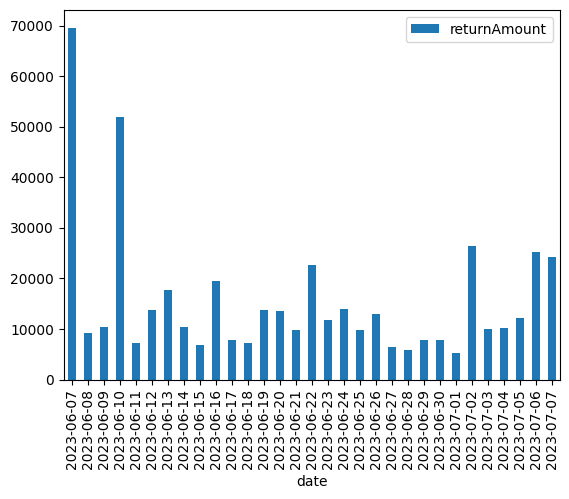

In [134]:
astro_sell[['date','returnAmount']].groupby('date').sum().plot(kind='bar')

<Axes: xlabel='date'>

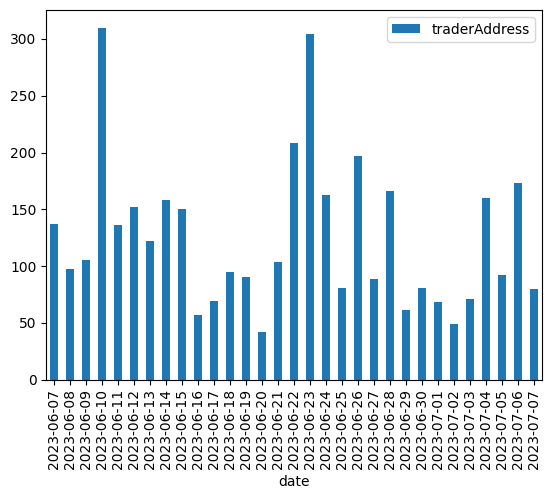

In [135]:
astro_sell[['date','traderAddress']].groupby('date').count().plot(kind='bar')

In [136]:
df.to_csv(f'data/astro/swaps.csv', index=False)

In [162]:
import requests
import json

def get_balances(address):
    url = "https://starscream-terra-mainnet.chainscope.dev/"
    headers = {
        "Content-Type": "application/json"
    }
    
    body = {
        "query": """
        query Query($address: String!, $tokenContracts: [String!]!) {
            tokenBalances(address: $address, tokenContracts: $tokenContracts)
        }
        """,
        "variables": {
            "address": f"{address}",
            "tokenContracts": [
                "terra1x62mjnme4y0rdnag3r8rfgjuutsqlkkyuh4ndgex0wl3wue25uksau39q8",
                "terra1xp9hrhthzddnl7j5du83gqqr4wmdjm5t0guzg9jp6jwrtpukwfjsjgy4f3",
                "terra19p20mfnvwh9yvyr7aus3a6z6g6uk28fv4jhx9kmnc2m7krg27q2qkfenjw",
                "terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26",
                "terra1ecgazyd0waaj3g7l9cmy5gulhxkps2gmxu9ghducvuypjq68mq2s5lvsct",
                "terra1lxx40s29qvkrcj8fsa3yzyehy7w50umdvvnls2r830rys6lu2zns63eelv",
                "terra1lalvk0r6nhruel7fvzdppk3tup3mh5j4d4eadrqzfhle4zrf52as58hh9t",
                "terra1gwrz9xzhqsygyr5asrgyq3pu0ewpn00mv2zenu86yvx2nlwpe8lqppv584",
                "terra17aj4ty4sz4yhgm08na8drc0v03v2jwr3waxcqrwhajj729zhl7zqnpc0ml"
            ]
        },
        "operationName": "Query"
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        result = response.json()
        print(result)
    else:
        print("Request failed with status code:", response.status_code)

{'data': {'tokenBalances': ['0', '0', '0', '2316666660000', '0', '0', '0', '0', '0']}}


In [164]:
import json

# Specify the path to the JSON file
file_path = "./data/astro/top_sellers.json"

# Open the file and load the JSON data
with open(file_path, "r") as file:
    data = json.load(file)

# Now you can access the data as a Python object
print(data[0])

{'traderAddress': 'terra1pgvewpk8kd30f2zm85sn69k9cgkp3j8szq00j7', 'returnAmount': 16887.842132}
